In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels as sm
#!pip install statsmodels --upgrade
import statsmodels.api as sm
import matplotlib.ticker as mtick
from scipy.stats import jarque_bera
from sklearn.metrics import mean_squared_error


In this script you can find the code used in the report to generate the forecasts of the Euribor rates using Dynamic Nelson Siegel Model, the Vasicek Model and the random walk. Lastly, the code can be found that is used for simulating the Euribor rates.

In [2]:
rates=pd.read_excel('hypothetical_data_set.xlsx', sheet_name='Hypothetical rates', header=1)
portfolio=pd.read_excel('hypothetical_data_set.xlsx', sheet_name='Hypothetical portfolio', header=1)

In [3]:
ftp=rates.iloc[:,:6]
euribor=rates.iloc[:,7:]

In [4]:
euribor.iloc[:,1:].mean(axis=0)

6M      -0.000423
1Y      -0.000431
3Y.1     0.000865
5Y.1     0.003106
10Y.1    0.008531
dtype: float64

In [5]:
new_column_names = {'3Y.1': '3Y', '5Y.1': '5Y', '10Y.1': '10Y'}

# Rename columns
euribor.rename(columns=new_column_names, inplace=True)

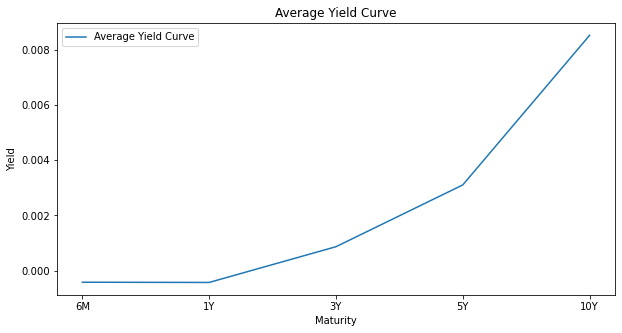

In [6]:
# STYLIZED FACT 1
# Calculate the average yield for each maturity
average_yield = euribor.iloc[:,1:].mean(axis=0)

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(euribor.columns[1:].values, average_yield.values, label='Average Yield Curve')

plt.xlabel('Maturity')
plt.ylabel('Yield')
plt.title('Average Yield Curve')

plt.legend()

plt.show()

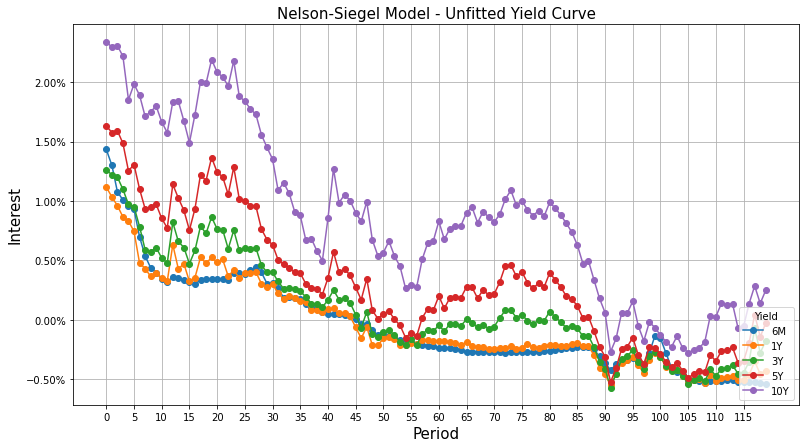

In [7]:
sf = euribor.copy()
sf = sf.dropna()
sf1 = sf.copy()
sf1['Y'] = round(sf['6M']*100, 4)

# Define columns to plot
columns_to_plot = ["6M", "1Y", "3Y", "5Y", "10Y"]

# Plotting
fig, ax = plt.subplots(figsize=(13, 7))
plt.title("Nelson-Siegel Model - Unfitted Yield Curve", fontsize=15)
#ax.set_facecolor("black")
#fig.patch.set_facecolor('white')

# Plot each column
for col in columns_to_plot:
    X = sf1.index
    Y = sf1[col] * 100  # Convert to percentage
    plt.plot(X.values, Y.values, label=f"{col}", marker="o")

plt.xlabel('Period', fontsize=15)
plt.ylabel('Interest', fontsize=15)
plt.xticks(np.arange(0, 120, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(title="Yield", loc="lower right")
plt.grid()
plt.show()

In [8]:
# STYLIZED FACT 3-5
# voor het maken van de tabel om de stylized facts te checken met autocorrelation
def lagSeries(column, lag):
    return column.shift(lag)

def autoCorrelation(series, lag):
    lag_series = lagSeries(series, lag)
    return series.corr(lag_series)

def makeTable():
    table = []
    maturities = ['6M','1Y','3Y','5Y','10Y']
    for maturity in maturities:
        series = euribor[maturity]
        row = {"maturity": maturity,
              "mean": series.mean(),
               "std": series.std(),
               "rho_1": autoCorrelation(series,1),
               "rho_6": autoCorrelation(series,6),
               "rho_12": autoCorrelation(series,12)}
        table.append(row)
    return pd.DataFrame(table)

print(makeTable().round(3))

  maturity   mean    std  rho_1  rho_6  rho_12
0       6M -0.000  0.004  0.994  0.922   0.879
1       1Y -0.000  0.004  0.985  0.925   0.918
2       3Y  0.001  0.004  0.980  0.905   0.842
3       5Y  0.003  0.005  0.978  0.882   0.762
4      10Y  0.009  0.007  0.981  0.883   0.740


In [9]:
# STYLIZED FACT 6
# Calculate cross-correlations


correlations = euribor.corr()

print(correlations)

          Date.1        6M        1Y        3Y        5Y       10Y
Date.1  1.000000 -0.904189 -0.926506 -0.903904 -0.883173 -0.888558
6M     -0.904189  1.000000  0.978877  0.945785  0.906102  0.869265
1Y     -0.926506  0.978877  1.000000  0.983605  0.954711  0.924067
3Y     -0.903904  0.945785  0.983605  1.000000  0.990970  0.968453
5Y     -0.883173  0.906102  0.954711  0.990970  1.000000  0.989733
10Y    -0.888558  0.869265  0.924067  0.968453  0.989733  1.000000


In [10]:
# Function to calculate cross-correlation with optional lag
def crossCorrelation(series1, series2, lag=0):
    lag_series = series2.shift(lag)
    return series1.corr(lag_series)
crossCorrelation(euribor['1Y'], euribor['3Y'], lag=0)

0.9836051135888911

### Dynamic Nelson Siegel

In [11]:
def create_ns_matrix(tau, lamb):
    tau = np.atleast_1d(tau)
    lamb = np.atleast_1d(lamb)
    ns_matrix = np.zeros((len(tau), 3))

    for i in range(len(tau)):
        ns_matrix[i, 0] = 1
        ns_matrix[i, 1] = (1 - np.exp(-lamb * tau[i])) / (lamb * tau[i])
        ns_matrix[i, 2] = ns_matrix[i, 1] - np.exp(-lamb * tau[i])

    ns_df = pd.DataFrame(ns_matrix, columns=['1', '(1-e^-λτ)/λτ', '(1-e^-λτ)/λτ - e^-λτ'])
    return ns_df

def estimate_betas(Y, tau_example, lambda_example):
    B = create_ns_matrix(tau_example, lambda_example)
    BBi = np.linalg.inv(B.T @ B)
    betas = np.linalg.inv(B.T @ B) @ B.T @ Y.T

    beta1 = betas.iloc[0, :]
    beta2 = betas.iloc[1, :]
    beta3 = betas.iloc[2, :]

    cs = []
    phis = []

    for beta in [beta1, beta2, beta3]:
        beta_lagged = beta[:-1].values
        beta_current = beta[1:].values
        beta_lagged_with_constant = sm.add_constant(beta_lagged)
        model = sm.OLS(beta_current, beta_lagged_with_constant)
        results = model.fit()

        c_estimate = results.params[0]
        phi_estimate = results.params[1]

        cs.append(c_estimate)
        phis.append(phi_estimate)

    beta1s = list(beta1.values)
    beta1_np = np.zeros(len(test_data.iloc[:, 1]))

    for i in range(len(test_data.iloc[:, 1])):
        beta1s.append(cs[0] + phis[0] * beta1s[-1])
        beta1_np[i] = cs[0] + phis[0] * beta1s[-1]

    beta2s = list(beta2.values)
    beta2_np = np.zeros(len(test_data.iloc[:, 1]))

    for i in range(len(test_data.iloc[:, 1])):
        beta2s.append(cs[1] + phis[1] * beta2s[-1])
        beta2_np[i] = cs[1] + phis[1] * beta2s[-1]

    beta3s = list(beta3.values)
    beta3_np = np.zeros(len(test_data.iloc[:, 1]))

    for i in range(len(test_data.iloc[:, 1])):
        beta1s.append(cs[2] + phis[2] * beta3s[-1])
        beta3_np[i] = cs[2] + phis[2] * beta3s[-1]

    betas = np.row_stack((beta1_np, beta2_np, beta3_np))
    return B, betas

# Sample data setup
train_data = euribor.iloc[:96, 1:]
test_data = euribor.iloc[96:, 1:]

# Define maturities
maturities = ["6M", "1Y", "3Y", "5Y", "10Y"]
Y = train_data.values

# Estimate betas
tau_example = np.array([6, 12, 36, 60, 120])
def find_optimal_lambda(train_data, test_data, tau_example, lambda_range):
    min_mse = float('inf')
    optimal_lambda = None

    for lambda_val in lambda_range:
        B, betas = estimate_betas(train_data.values, tau_example, lambda_val)
        y = B @ betas

        mse_values = []

        for j in range(len(test_data)):
            forecast_y = y.iloc[:, j]
            real_y = test_data.iloc[j, :]
            squared_diff = (forecast_y - real_y.values) ** 2
            mse = np.mean(squared_diff)
            mse_values.append(mse)

        avg_mse = np.mean(mse_values)

        if avg_mse < min_mse:
            min_mse = avg_mse
            optimal_lambda = lambda_val

    return optimal_lambda, min_mse

# Define the range of lambda values to search over
lambda_range = np.arange(0.1, 3.0, 0.1)

# Call the function to find the optimal lambda
optimal_lambda, min_mse = find_optimal_lambda(train_data, test_data, tau_example, lambda_range)

print("Optimal Lambda:", optimal_lambda)
print("Minimum Root Mean Squared Error:", np.sqrt(min_mse))


Optimal Lambda: 0.1
Minimum Root Mean Squared Error: 0.002495362874984771


In [12]:
lambda_example = 0.1      # Replace with desired λ value
tau_example = np.array([6, 12, 36, 60, 120])
Y = train_data.values
B, betas = estimate_betas(Y, tau_example, lambda_example)
y = B@betas


In [13]:
y=y.T
new_column_names = {0: '6M', 1: '1Y', 2: '3Y', 3:'5Y', 4:'10Y'}

# Rename columns
y.rename(columns=new_column_names, inplace=True)
y=y.set_index(test_data.index)


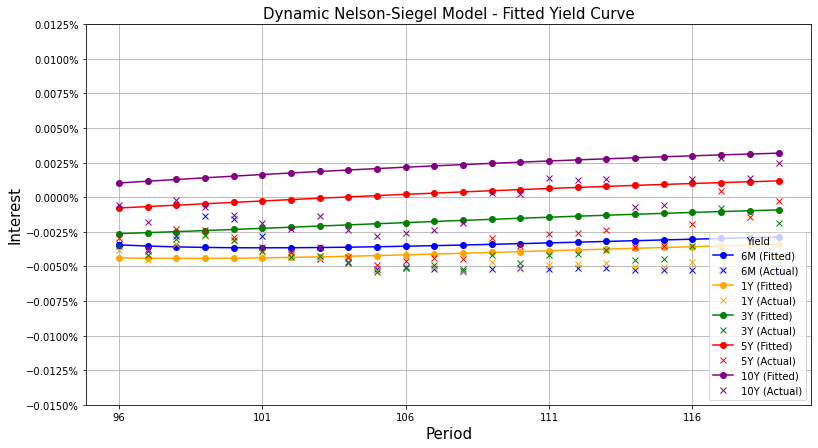

In [76]:
# Create a copy of the transposed DataFrame
sf = y.copy()

# Drop any rows with missing values
sf = sf.dropna()

# Create a copy of the DataFrame sf
sf1 = sf.copy()

# Multiply by 100 to convert to percentage and round to 4 decimal places
sf1['Y'] = round(sf1['6M'] * 100, 4)

# Define columns to plot
columns_to_plot = ["6M", "1Y", "3Y", "5Y", "10Y"]

# Plotting
fig, ax = plt.subplots(figsize=(13, 7))
plt.title("Dynamic Nelson-Siegel Model - Fitted Yield Curve", fontsize=15)
#ax.set_facecolor("black")
#fig.patch.set_facecolor('white')

# Define colors for each column
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Plot each column from sf1 and test_data
for idx, col in enumerate(columns_to_plot):
    X = sf1.index
    Y = sf1[col]  # Fitted data
    plt.plot(X.values, Y.values, label=f"{col} (Fitted)", marker="o", color=colors[idx])
    
    i = test_data.index
    k = test_data[col]  # Test data for the same maturity
    plt.plot(i.values, k.values, marker='x', linestyle='None', label=f"{col} (Actual)", color=colors[idx])

plt.xlabel('Period', fontsize=15)
plt.ylabel('Interest', fontsize=15)
plt.xticks(np.arange(96, 120, 5))
plt.yticks(np.arange(-0.015, 0.015, 0.0025))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(title="Yield", loc="lower right")
plt.grid()
plt.savefig('dynamic_nelson_siegel.png')
plt.show()


### Random walk

In [58]:
#benchmark random walk
def random_walk(series, months):
    k = series.iloc[-1]
    return k

maturities = ["6M", "1Y", "3Y", "5Y", "10Y"]

Y = train_data

Y = Y.values

forecast_results_df = pd.DataFrame(index=maturities, columns=range(1, 25))

for maturity in maturities:
    series = train_data[maturity]

    for horizon in range(1, 25):
        forecast_key = f'Maturity_{maturity}Horizon{horizon}'

        # Expanding window forecast

        forecast = random_walk(series, horizon)

        forecast_results_df.loc[maturity, horizon] = forecast

In [59]:
forecast_results_df=forecast_results_df.T
forecast_results_df=forecast_results_df.set_index(test_data.index)
#forecast_results_df

In [60]:
MSE2=mean_squared_error(test_data, forecast_results_df)
print(f"The mean RMSE RW",np.sqrt(MSE2))

The mean RMSE RW 0.0019219474867089024


In [23]:
# Define the index range
index_range = range(24)

# Define the column names
column_names = ["6M", "1Y", "3Y", "5Y", "10Y"]

# Create the DataFrame
e = pd.DataFrame(index=index_range, columns=column_names)
e.iloc[:,0]=(test_data.iloc[:,0]-forecast_results_df.iloc[:,0]).values
e.iloc[:,1]=(test_data.iloc[:,1]-forecast_results_df.iloc[:,1]).values
e.iloc[:,2]=(test_data.iloc[:,2]-forecast_results_df.iloc[:,2]).values
e.iloc[:,3]=(test_data.iloc[:,3]-forecast_results_df.iloc[:,3]).values
e.iloc[:,4]=(test_data.iloc[:,4]-forecast_results_df.iloc[:,4]).values



In [24]:
e = e.apply(pd.to_numeric, errors='coerce')

### Vasicek model

In [61]:
n = len(train_data)
expected_forecast = np.zeros((len(test_data),5))
a_vasi_list = []
lr_mu_vasi_list = []
var_vasi_list = []
for j in range(0,5):
    a_vasi = -1 / 12 * np.log((n * sum(euribor.iloc[0: (n - 2),j+1].values * euribor.iloc[1 : (n-1), j+1].values) - sum(euribor.iloc[ 1 : (n-1),j+1].values) * sum(euribor.iloc[0: (n - 2),j+1].values))/(n * sum(euribor.iloc[0 : (n - 2),j+1]**2) - sum(euribor.iloc[0 : (n - 2),j+1])**2))
    lr_mu_vasi = 1 / (n * (1 - np.exp(-a_vasi / 12))) * (sum(euribor.iloc[1 : (n-1),j+1]) - np.exp(a_vasi / 12) * sum(euribor.iloc[0 : (n - 2),j+1]))
    #var_vasi = 2 * a_vasi / (n * (1 - np.exp(-a_vasi / 6))) * sum((euribor.iloc[1 : (n-1),j+1] - euribor.iloc[0 : (n -2),j+1] * np.exp(-a_vasi/12) - lr_mu_vasi * (1 - np.exp(-a_vasi/12)))**2)
    var_vasi = 2 * a_vasi / (n * (1 - np.exp(-a_vasi / 6))) * sum((euribor.iloc[1 : (n-1),j+1].values - euribor.iloc[0 : (n -2),j+1].values * np.exp(-a_vasi/12) - lr_mu_vasi * (1 - np.exp(-a_vasi/12)))**2)
    
    a_vasi_list.append(a_vasi)
    lr_mu_vasi_list.append(lr_mu_vasi)
    var_vasi_list.append(var_vasi)
    
    expected_forecast[0] = train_data.iloc[-1,j] * np.exp(-a_vasi/12) + lr_mu_vasi * (1 - np.exp(-a_vasi / 12))
    for i in range(1, len(test_data)):
        expected_forecast[i,j] = expected_forecast[i - 1, j] * np.exp(-a_vasi/12) + lr_mu_vasi * (1 - np.exp(-a_vasi / 12))

results_df = pd.DataFrame({
    'a_vasi': a_vasi_list,
    'lr_mu_vasi': lr_mu_vasi_list,
    'var_vasi': var_vasi_list
})

expected_forecast=pd.DataFrame(expected_forecast)

# Define new column names
new_column_names = ["6M", "1Y", "3Y", "5Y", "10Y"]
expected_forecast=expected_forecast.set_index(test_data.index)
# Change column names
expected_forecast.columns = new_column_names

mse_vasi_paper = mean_squared_error(test_data, expected_forecast)
print(np.sqrt(mse_vasi_paper))

0.0023007631264548092


In [55]:
results_df

,a_vasi,lr_mu_vasi,var_vasi
0,0.005826,-0.381799,0.000002
1,0.004928,-0.369276,0.000006
2,0.004339,-0.453869,0.000009
3,0.004044,-0.580045,0.000016
4,0.002924,-0.988825,0.000025


In [56]:
print("Mean MSE DNS:", np.sqrt(min_mse))
print(f"The mean MSE RW",np.sqrt(MSE2))
print("Average MSE Vasicek MLE:", np.sqrt(mse_vasi_paper))

Mean MSE DNS: 0.002495362874984771
The mean MSE RW 0.0019219474867089024
Average MSE Vasicek MLE: 0.0023007631264548092


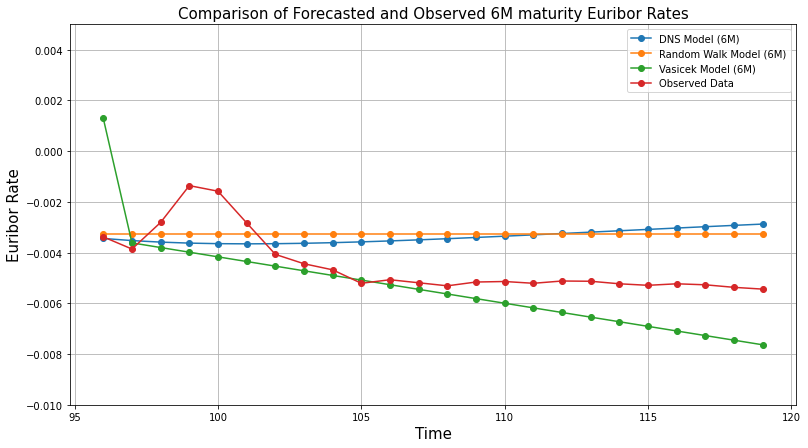

In [49]:
y_RW_6M = forecast_results_df['6M']
#y_RW_6M_df = pd.DataFrame(y_RW_6M, index=test_data.index, columns=['1Y Random Walk'])
y_NS_6M = y['6M']
y_VAS_6M = expected_forecast['6M']
y_org = euribor.iloc[-24:,1]
# Plotting
plt.figure(figsize=(13, 7))
plt.plot(y_NS_6M, label='DNS Model (6M)', marker='o')
plt.plot(y_RW_6M, label='Random Walk Model (6M)', marker='o')
plt.plot(y_VAS_6M, label='Vasicek Model (6M)', marker='o')
plt.plot(y_org, label='Observed Data', marker='o')
plt.ylim(-0.010, 0.005)
plt.title('Comparison of Forecasted and Observed 6M maturity Euribor Rates', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Euribor Rate', fontsize=15)
plt.legend()
plt.grid(True)
plt.savefig('forecast_yield.png')
plt.show()

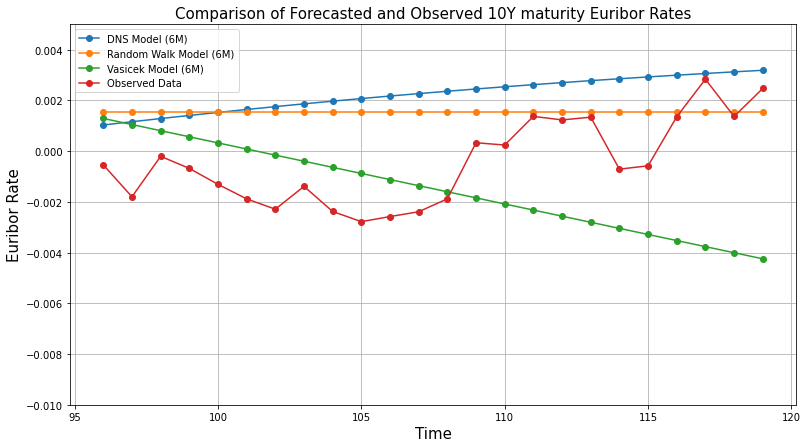

In [52]:
y_RW_6M = forecast_results_df['10Y']
#y_RW_6M_df = pd.DataFrame(y_RW_6M, index=test_data.index, columns=['1Y Random Walk'])
y_NS_6M = y['10Y']
y_VAS_6M = expected_forecast['10Y']
y_org = euribor.iloc[-24:,5]
# Plotting
plt.figure(figsize=(13, 7))
plt.plot(y_NS_6M, label='DNS Model (6M)', marker='o')
plt.plot(y_RW_6M, label='Random Walk Model (6M)', marker='o')
plt.plot(y_VAS_6M, label='Vasicek Model (6M)', marker='o')
plt.plot(y_org, label='Observed Data', marker='o')
plt.ylim(-0.010, 0.005)
plt.title('Comparison of Forecasted and Observed 10Y maturity Euribor Rates', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Euribor Rate', fontsize=15)
plt.legend()
plt.grid(True)
plt.savefig('forecast_yield_10Y.png')
plt.show()

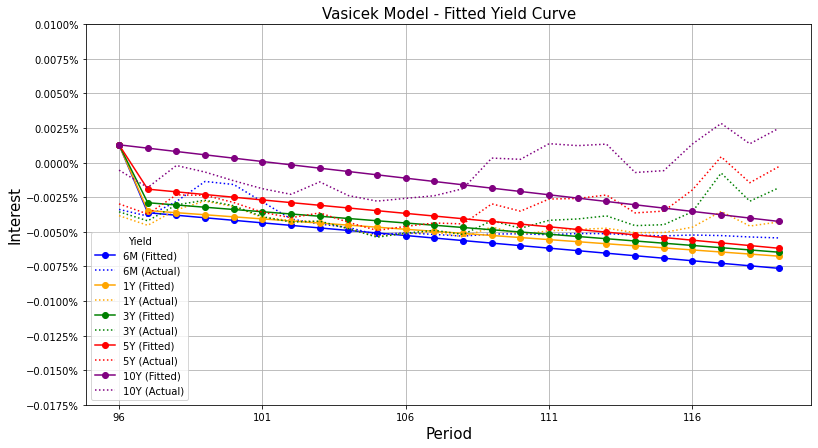

In [75]:
# Create a copy of the transposed DataFrame
sf = expected_forecast.copy()

# Drop any rows with missing values
sf = sf.dropna()

# Create a copy of the DataFrame sf
sf1 = sf.copy()

# Multiply by 100 to convert to percentage and round to 4 decimal places
sf1['Y'] = round(sf1['6M'] * 100, 4)

# Define columns to plot
columns_to_plot = ["6M", "1Y", "3Y", "5Y", "10Y"]

# Plotting
fig, ax = plt.subplots(figsize=(13, 7))
plt.title("Vasicek Model - Fitted Yield Curve", fontsize=15)
#ax.set_facecolor("black")
#fig.patch.set_facecolor('white')

# Define colors for each column
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Plot each column from sf1 and test_data
for idx, col in enumerate(columns_to_plot):
    X = sf1.index
    Y = sf1[col]  # Fitted data
    plt.plot(X.values, Y.values, label=f"{col} (Fitted)", marker="o", color=colors[idx])
    
    i = test_data.index
    k = test_data[col]  # Test data for the same maturity
    plt.plot(i.values, k.values, linestyle='dotted', label=f"{col} (Actual)", color=colors[idx])

plt.xlabel('Period', fontsize=15)
plt.ylabel('Interest', fontsize=15)
plt.xticks(np.arange(96, 120, 5))
plt.yticks(np.arange(-0.0175, 0.01, 0.0025))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(title="Yield", loc="lower left")
plt.grid()
plt.savefig('vasicek.png')
plt.show()


### Simulate the Euribor rates from the Vasicek model

In [77]:
R0 = euribor.iloc[0,1:]
alpha = a_vasi_list
sigma = var_vasi_list
r = lr_mu_vasi_list

In [78]:
# Number of time steps
T = 120

# Initialize arrays to store simulated rates
simulated_rates = np.zeros((T, 5))

# Simulate rates for each maturity
for j in range(5):
    for t in range(0, T):
        m_t = R0[j] * np.exp(-alpha[j] * (t+1)/12) + r[j] * (1 - np.exp(-alpha[j] * (t+1)/12))
        var_t = (sigma[j] / (2 * alpha[j])) * (1 - np.exp(-2 * alpha[j] * (t+1)/12))
        simulated_rates[t , j] = np.random.normal(m_t, np.sqrt(var_t))

simulated_rates = pd.DataFrame(simulated_rates)
new_column_names = {0:'6M', 1 : '1Y', 2: '3Y', 3: '5Y', 4: '10Y'}
# Rename columns
simulated_rates.rename(columns=new_column_names, inplace=True)

# Display the simulated rates
print(simulated_rates)

           6M        1Y        3Y        5Y       10Y
0    0.015670  0.011438  0.012033  0.016213  0.023131
1    0.013791  0.011406  0.013930  0.012931  0.024518
2    0.014150  0.010132  0.013981  0.015581  0.024587
3    0.012979  0.011593  0.011116  0.016429  0.022240
4    0.013691  0.009868  0.012301  0.015438  0.022490
..        ...       ...       ...       ...       ...
115 -0.012085 -0.003174 -0.005681  0.013629 -0.023590
116 -0.006316 -0.007950 -0.007455 -0.010045 -0.003244
117 -0.010489 -0.004560 -0.004177 -0.014546 -0.013564
118 -0.015815 -0.002661 -0.004628 -0.006995 -0.016658
119 -0.006459 -0.006700 -0.011025 -0.007238 -0.032242

[120 rows x 5 columns]
